In [2]:
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from keras import optimizers,regularizers
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
np.random.seed(13)
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import math
from __future__ import division
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize
from stockstats import StockDataFrame 
from googlefinance.client import get_price_data, get_prices_data, get_prices_time_data

import dataPreparation
files=['PEP']#,'AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX','ADBE','AMGN','TXN','AVGO','PYPL','GILD','COST','QCOM']       
prices=list()
for file in files:
    param = {
        'q': file, # Stock symbol (ex: "AAPL")
        'i': "900", # Interval size in seconds ("86400" = 1 day intervals)
        'x': "NASD", # INDEXNASDAQStock exchange symbol on which stock is traded (ex: "NASD")
        'p': "2Y" # Period (Ex: "1Y" = 1 year)
        }
    
    priceData = get_price_data(param)
    stock = StockDataFrame.retype(priceData)
    price = pd.DataFrame(stock)
    string=['close_2_sma','close_4_sma','close_6_sma','close_8_sma','close_10_sma','close_12_sma','close_14_sma','close_16_sma','close_18_sma','pdi','mdi','dx','adx','adxr','cr','cr-ma1','cr-ma2','cr-ma3','boll','boll_ub','boll_lb','volume_-2_d','volume_-4_d','volume_-6_d','volume_-8_d','volume_-10_d','volume_-12_d','macd','macds','macdh','kdjk','kdjd','kdjj','tr','atr','wr_2','wr_10','wr_6','wr_8','wr_12','wr_14','close_-2_d','close_-4_d','close_-6_d','close_-8_d','close_-10_d','close_-12_d','close_-14_d','close_-16_d','rsi_2','rsi_4','rsi_6','rsi_8','rsi_10','rsi_12','rsi_14','rsi_16']

    stock.get(string)
    price = stock
    print(price)
    
    #['macd','macds', 'boll_ub', 'boll_lb','rsi_6','rsi_12','vr_6_sma','wr_10','wr_6''close_10_sma''tr''middle_{}_sma'
    #df['dma'] = df['close_10_sma'] - df['close_50_sma'] pdi'] = cls._get_pdi(df, 14)df['mdi'] = cls._get_mdi(df, 14)
    #df['dx'] = cls._get_dx(df, 14) df['adx'] = df['dx_6_ema'] df['adxr'] = df['adx_6_ema']]
    #
    
    prices.append(prices.append(price))

/home/andrea/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


                         open      high       low     close   volume  \
2017-12-20 22:30:00  118.6600  118.7100  118.6600  118.7000    43248   
2017-12-20 22:45:00  118.9500  119.1200  117.5600  117.8200    69261   
2017-12-20 23:00:00  117.8200  118.3200  117.7700  118.2300   163492   
2017-12-20 23:15:00  118.2200  118.4200  118.0900  118.1800    49993   
2017-12-20 23:30:00  118.1800  118.2452  118.0600  118.2400    40796   
2017-12-20 23:45:00  118.2400  118.2500  118.0000  118.1000    43877   
2017-12-21 00:00:00  118.1300  118.2400  118.0500  118.1200    41672   
2017-12-21 00:15:00  118.1101  118.2100  118.0600  118.0600    32619   
2017-12-21 00:30:00  118.0874  118.1400  117.9200  118.0899    28223   
2017-12-21 00:45:00  118.0900  118.0900  117.9300  118.0500    31569   
2017-12-21 01:00:00  118.0500  118.1700  117.9900  118.0050    28177   
2017-12-21 01:15:00  118.0108  118.0900  117.9000  118.0000    87431   
2017-12-21 01:30:00  117.9850  118.1000  117.9850  118.0200    4

In [2]:
def smote(x,y):
    X_resampled, y_resampled = SMOTE().fit_sample(x, y)
    #print('check',sum(y_resampled)/len(y_resampled))
    return X_resampled,y_resampled
def balance(x,y):
    posindex=np.where( y == 1 )
    negindex=np.where( y == 0 )
    xt=[]
    yt=[]
    yindex=[]
    nindex=min(len(posindex[0]),len(negindex[0]))

    #for i in range(1,nindex):
    yt=np.concatenate((y[posindex[0][0:nindex]],y[negindex[0][0:nindex]]))
    xt=np.concatenate((x[posindex[0][0:nindex]],x[negindex[0][0:nindex]]))
    
    return xt,yt

def balanceup(x,y):
    posindex=np.where( y == 1 )
    negindex=np.where( y == 0 )
    xt=[]
    yt=[]
    yindex=[]
    
    if(len(posindex[0])!=0 and len(negindex[0])!=0):
       
        nindex=max(len(posindex[0]),len(negindex[0]))
        mini=min(len(posindex[0]),len(negindex[0]))
        diff=nindex-mini
        u=0
        for i in range(0,mini):
            yt.append(y[posindex[0][i]])
            yt.append(y[negindex[0][i]])
            xt.append(x[posindex[0][i]])
            xt.append(x[negindex[0][i]])
        #print('first',sum(yt)/len(yt)) 
        if(len(posindex[0])>len(negindex[0])):
            toextract=negindex
            enter=posindex
        else:
            toextract=posindex
            enter=negindex
        if(diff!=0 and len(toextract[0])!=0):
            for i in range(0,diff):
                r=np.random.randint(0,len(toextract))
                yt.append(y[toextract[0][r]])
                xt.append(x[toextract[0][r]])
                yt.append(y[enter[0][mini+i]])
                xt.append(x[enter[0][mini+i]])
    else:
        #print('Unbalance')
        u=1
        xt=x
        yt=y
    #print(sum(yt)/len(yt))              
    return xt,yt,u
                    

In [3]:
def buildModel(l,n,d):
    model = Sequential()  
    model.add(Dense(n, input_dim=111,activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dropout(d))
    model.add(Dense(math.floor(n/2), activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU())
    model.add(Dropout(d))
    model.add(Dense(math.floor(n/4), activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dense(1, activation='sigmoid')) 
    
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

    return model

def findMaxAcc(valacc,valloss):
	prevloss=valloss[0]
	for i in range(1,len(valloss)):
		if(valloss[i]>prevloss):
			return valacc[i-1]
	#print('Problems with find MaxAccuracy')
	return valacc[len(valacc)-1]
def findMaxAccStep(valacc,valloss):
	prevloss=valloss[0]
	for i in range(1,len(valloss)):
		if(valloss[i]>prevloss):
			return i-1
	#print('Problems with find MaxAccuracy')
	return len(valacc)-1

Working on... AAPL
window time  200


/home/andrea/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


working on d,u and l 0.5 20 0.05
---------------------------------------------------------
---------------------------------------------------------


/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[43.31614257267543, 67.6629658290318, 50.50148985726493, 25.45437905447824, 14.723555769239153, 12.058803067888533, 9.711726461138044, 8.941819899422782, 7.892180020468576, 6.999541119166783, 6.786479949951172, 6.249706840515136, 5.387280668531146, 5.491422217232841, 5.060285895211356, 4.615201595851353, 4.421223415647234, 4.2442749432155065, 4.034252309799195, 3.8130022491727558, 3.6274351801191056, 3.5866857051849363, 3.3523735761642457, 3.232012782778059, 3.0624755791255405, 2.947342480931963, 2.8595651149749757, 2.848783132008144, 2.694151224408831, 2.545899793079921, 2.4646533148629324, 2.383595783369882, 2.3433664219720023, 2.1722041164125714, 2.141447298867362, 2.0566523824419294, 1.9909015451158796, 1.9244412626538958, 1.8622375215802873, 1.8060918399265835, 1.746804734638759, 1.7100047520228794, 1.6677827051707677, 1.6047609874180384, 1.5707079478672572, 1.5067276307514736, 1.452869553225381, 1.4318346755845206, 1.3895017913409642, 1.3777228559766497, 1.3353396364620753, 1.311

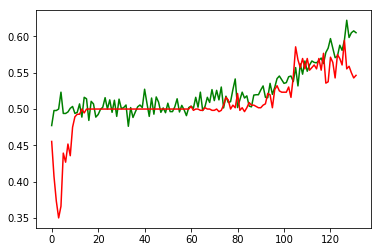

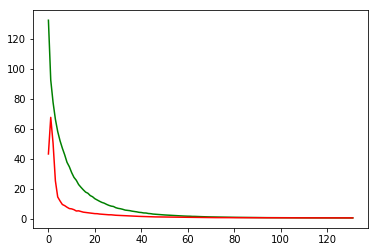

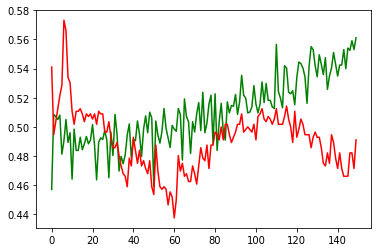

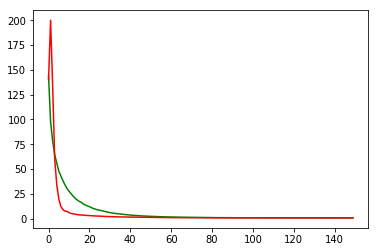

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[91.13028735573958, 83.4272266341607, 29.392339745031194, 13.412455678468774, 10.749906817911125, 8.966966196593003, 6.527157223659006, 6.478596266464666, 5.429844574407045, 4.532718571574099, 3.995151172282725, 3.848308441609989, 3.752009685222919, 3.7478591343651897, 3.1514768619769016, 3.2738752789825565, 2.8357132687742412, 2.646932118334751, 2.4806389876222803, 2.353005017346216, 2.2322266179057753, 2.1454884151698126, 2.1079138300196845, 1.907464211286321, 1.8365598275111272, 1.7895326923262254, 1.7019088263453743, 1.646402915479683, 1.5645539152477435, 1.4920537915789647, 1.4717361270657434, 1.4371977870763555, 1.3930403901497845, 1.348415453424338, 1.29372503979486, 1.2915725326731138, 1.2491460280862414, 1.2367402498538678, 1.1813251721231561, 1.159799095590105, 1.139385150029109, 1.1283061398185699, 1.0851326611360557, 1.0803977169005976, 1.0476116065071661, 1.0278835291804573, 1.019769550817698, 1.0024199657111998, 0.9888364544764221, 0.9754236111274133, 0.9638927156625972, 

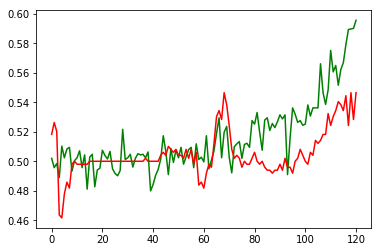

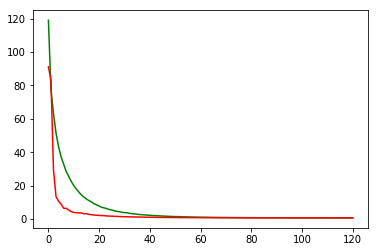

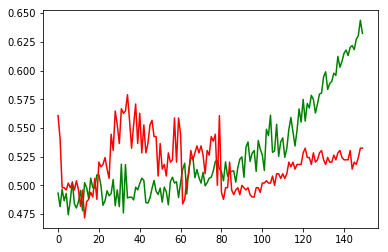

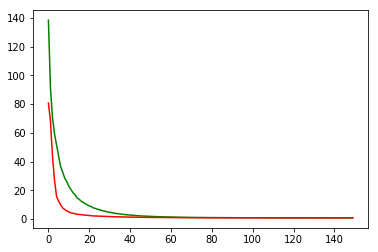

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[107.80952554145014, 93.6407194378574, 55.0230888683443, 23.046682235566287, 12.465810414255742, 6.912100162747104, 5.949105483960589, 4.735862466402432, 4.091418227133768, 3.8549229431668772, 3.3184953493331744, 3.2362258154562666, 2.873058084546444, 2.635200155771166, 2.536242463098106, 2.3442541094032867, 2.1523536478139005, 2.0763518487503383, 1.9290955798290266, 1.8317264120501302, 1.7425483200524259, 1.6199253483369462, 1.5610712161993723, 1.4836578666087952, 1.4038869420113547, 1.3470930736848163, 1.3076974661341643, 1.2298126543471959, 1.2169067211960196, 1.1444011814757804, 1.1381881135895795, 1.077988162367783, 1.0497740360803982, 1.015543381444814, 0.9895597029248729, 0.9749394825219247, 0.9530770520440939, 0.9446247331932563, 0.9233545972982469, 0.902819597118598, 0.8908252819350481, 0.8806965041246655, 0.8689403693168172, 0.8577448671905573, 0.8536843728502735, 0.8381849490778541, 0.833938271130035, 0.8261443428184151, 0.8179882336609631, 0.8168995432044625, 0.806816503244

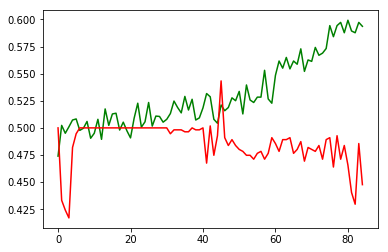

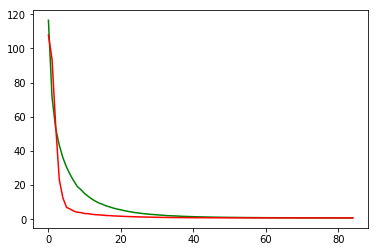

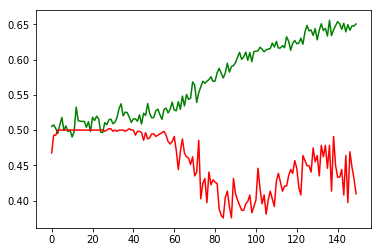

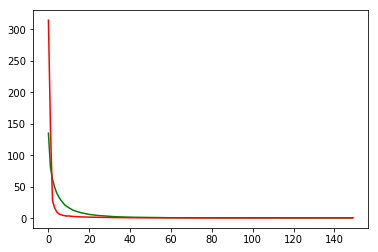

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[92.54667030734781, 27.221348309222563, 15.386560763841794, 11.603760729601353, 10.117328337681146, 8.151515381571688, 7.02581078329204, 6.0632945703871455, 5.902699394726459, 5.255417909887102, 4.857244614465737, 4.436246198636514, 4.260876391404941, 3.976204788243329, 3.6531431601371294, 3.459320746822122, 3.4112395533808955, 3.074382656886254, 2.856618423520783, 2.812935706274009, 2.6733247814355074, 2.43333375306777, 2.3894935544626215, 2.2021559521004006, 2.096398110742922, 1.9716772900687323, 1.8975953901255573, 1.8340096804830763, 1.7374250925617454, 1.6806855930222406, 1.6386322945724299, 1.5451700415140317, 1.4886131308696888, 1.4569048528318052, 1.3894394246148474, 1.3451887818030368, 1.2914202507631278, 1.2649063968364103, 1.2178961936338448, 1.1896661821706795, 1.1626795912966317, 1.1385354517418662, 1.1214963219783924, 1.1025305603757316, 1.0735102656446858, 1.046762392108823, 1.026114257765405, 1.008703660817794, 0.9983613549927135, 0.9840983203899714, 0.9616595315344539,

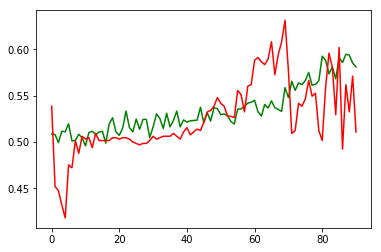

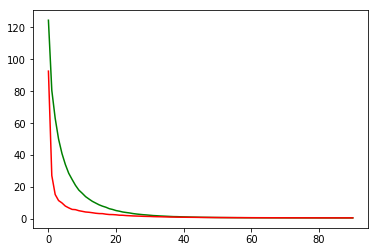

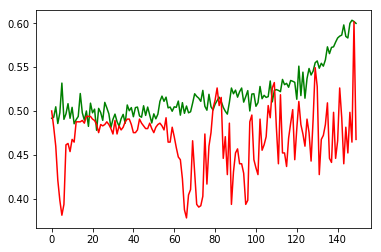

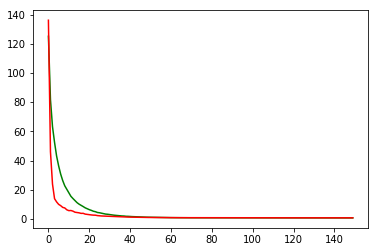

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[84.79308200412326, 34.428162553575305, 13.161228519015841, 8.319998575846354, 6.191315019395616, 5.059384809070163, 4.3953827179802785, 3.7013537957933216, 3.4240832826826306, 3.165521369510227, 2.864013673464457, 2.503496452967326, 2.4687879668341743, 2.1463190841674806, 1.9840498076544868, 1.8795421208275689, 1.737807724210951, 1.682324325773451, 1.558671604262458, 1.4590393670399984, 1.3944758285416496, 1.331814041402605, 1.3302403301662868, 1.2188876565297444, 1.1647154365645516, 1.152274469004737, 1.0967133728663128, 1.062354728910658, 1.040405567487081, 1.0075243881013658, 0.9884294173452589, 0.9646019079950121, 0.9507465020815531, 0.9365501917733087, 0.9151506193478902, 0.9050590780046252, 0.8937468014823066, 0.8827635629971822, 0.872747015423245, 0.8655497225125631, 0.8523709527651468, 0.8488761393229166, 0.8414273148112826, 0.8329032113817003, 0.831898595492045, 0.8194400805897183, 0.8167966704898411, 0.8142776637607151, 0.8098421767022874, 0.8014735542403327, 0.7964171727498

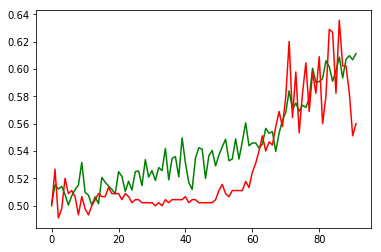

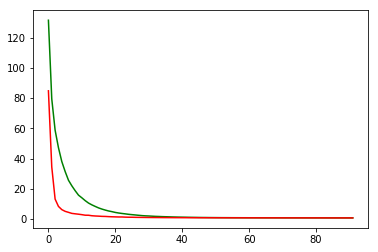

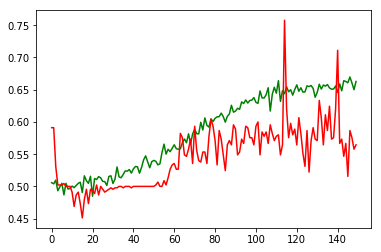

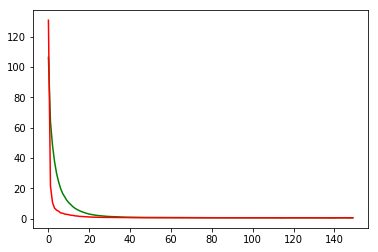

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[82.23443746223724, 39.2380237304907, 13.395988213930199, 7.803255033149994, 6.2773474240474565, 5.217293587519968, 4.671068301303781, 4.239300084628647, 4.130054272336068, 3.710375206075984, 3.3332193884060537, 2.9874937199860168, 2.791559450917964, 2.5859634078663887, 2.4144230266269164, 2.195351001170042, 2.0156283335720033, 1.9265136139855967, 1.7634497310617845, 1.6487853685728937, 1.5899500323714113, 1.4576411058576844, 1.3986297768654583, 1.3237101710099968, 1.2624035979346406, 1.2153423385654423, 1.173305361819782, 1.129893005323067, 1.101235562948872, 1.058790072262716, 1.0344521287533877, 1.0143524704219626, 0.9880686848283672, 0.971584260892525, 0.956694483757019, 0.935503825009298, 0.9224017699845404, 0.9156581103372917, 0.9017829136025134, 0.8922872972145355, 0.8821864106672274, 0.8747589553860452, 0.8630276862665903, 0.860835506332864, 0.8507244475453878, 0.8476609244621057, 0.8386202909105973, 0.8350908233107422, 0.8288110593240038, 0.8252686339316608, 0.8186945044737068

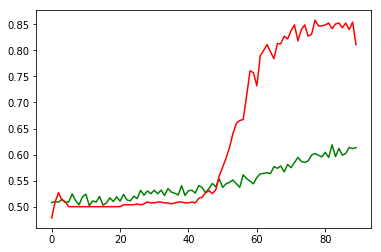

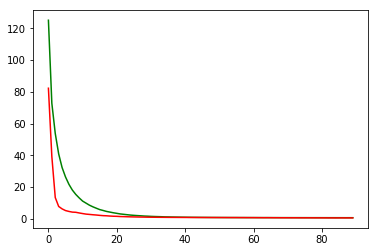

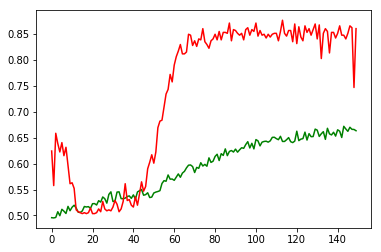

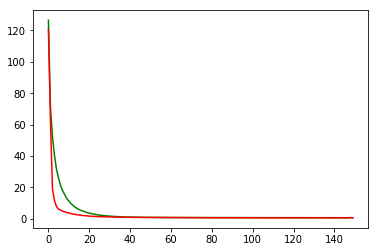

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
BEST FOT THIS MODEL VALIDATION ACCURACY: 0.5704323758344209
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
working on d,u and l 0.5 20 0.01
---------------------------------------------------------
---------------------------------------------------------


/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[17.981677627563478, 20.57380120413644, 10.557239750453403, 4.539484739303589, 2.9495085307529996, 2.606489396095276, 2.149377996580941, 2.101721566064017, 1.8467612947736467, 1.7314358813422066, 1.6607785378183637, 1.5401659607887268, 1.5107094151633127, 1.5233092273984636, 1.4225492647715978, 1.337631664957319, 1.3183608276503427, 1.2851635575294496, 1.2461106504712787, 1.2318442957741873, 1.2222195523125785, 1.1946523240634372, 1.197231183733259, 1.1667813335146222, 1.1445635897772652, 1.121399642739977, 1.0981938447271073, 1.0800184624535696, 1.048555018220629, 1.0285974860191345, 1.015017250605992, 0.9991971884455, 0.9977121438298907, 0.9696384498051235, 0.9590187430381775, 0.9424057023865836, 0.9417316607066564, 0.9181144101279123, 0.9110869509833199, 0.8976858156067985, 0.8870124169758388, 0.8754900557654245, 0.8684275797435216, 0.8605946847370692, 0.8487215501921518, 0.849843955039978, 0.8348832385880607, 0.8334124105317252, 0.8244053653308323, 0.8193537984575544, 0.81459645203

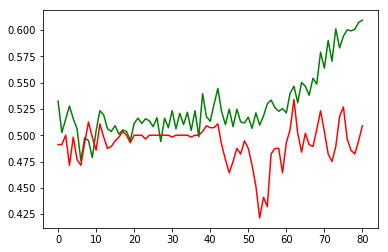

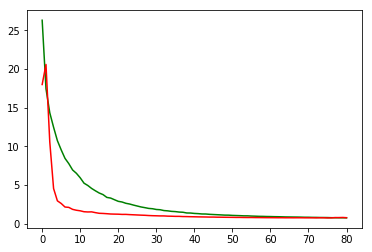

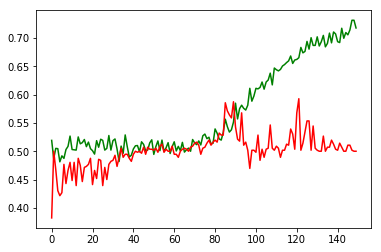

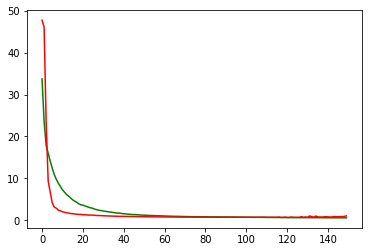

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[58.62922016715231, 52.90452997308029, 18.263121485227515, 8.057999448737634, 4.499557097431136, 3.231264922300331, 2.466703176498413, 2.215113495042932, 1.816038123991808, 1.7006450442650058, 1.5886728845627203, 1.4907862271374537, 1.3903586883776584, 1.342291972897796, 1.2960061973888382, 1.2214648593292545, 1.2119492147615565, 1.1702933601039625, 1.1308083138485185, 1.0957584800990487, 1.0701614985099206, 1.045364759952916, 1.0256310527623906, 1.002794861793518, 0.9850759525530735, 0.9627605541514964, 0.9515351568639037, 0.9344465563654417, 0.9267615808649101, 0.9024254657961579, 0.885360698226975, 0.877249663899302, 0.8617886295202772, 0.8550749121889895, 0.8454885111163984, 0.8354702184074804, 0.8286496391180556, 0.823087564364136, 0.8180549738378178, 0.8104678935367569, 0.805311449143568, 0.7995825960085943, 0.7920260685175536, 0.7881335654722051, 0.7827716607313889, 0.7808507765352968, 0.779494324676421, 0.7746893387091788, 0.7673681482129734, 0.765573568913618, 0.76300241131531

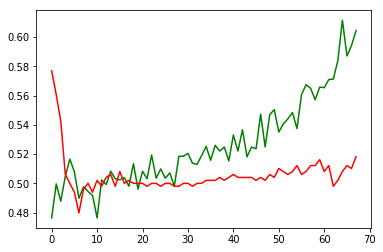

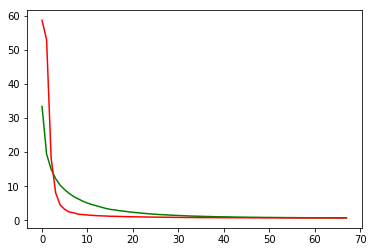

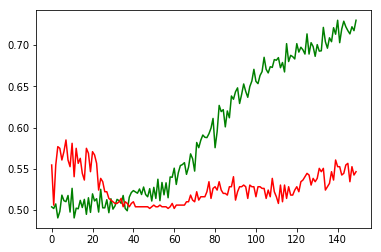

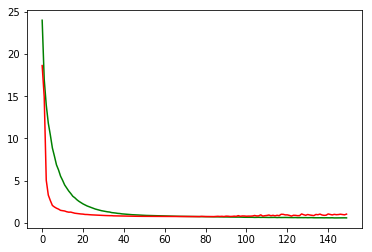

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[30.33115703706707, 8.745297839925607, 3.7484192452275797, 2.9281819899590005, 2.465497708492761, 2.2568359508411118, 1.806329980223618, 1.650428960900014, 1.5327363692035745, 1.476226484517328, 1.4337662572464789, 1.3299868337083809, 1.2906446706517078, 1.2633830016270442, 1.231346529098194, 1.1886949351978646, 1.1633929459626924, 1.1048102699462257, 1.0863533278234598, 1.0572614237289566, 1.0337048842158127, 1.0037885252319088, 0.9762984376521747, 0.9500239868026348, 0.9405803643839454, 0.9186171841965686, 0.8948722544129575, 0.8796544292343222, 0.8670442960752908, 0.8578344077840179, 0.8528969451408523, 0.8317470610787292, 0.8186661981933814, 0.8095755676069845, 0.8026444371856938, 0.7974594050366095, 0.7890523388067308, 0.7806546554668715, 0.775340500506253, 0.7682683726080057, 0.7636939218328318, 0.7582419013288477, 0.7559462579148771, 0.7508058724420595, 0.7483721528242642, 0.7452091279873349, 0.740823016269973, 0.7387811382324687, 0.7359616442277543, 0.7330395355551682, 0.731241

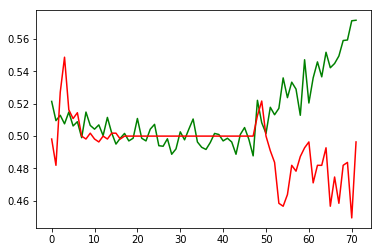

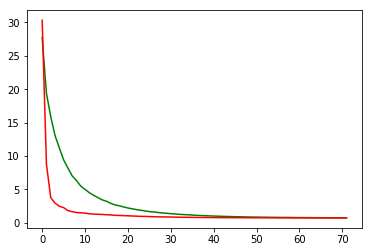

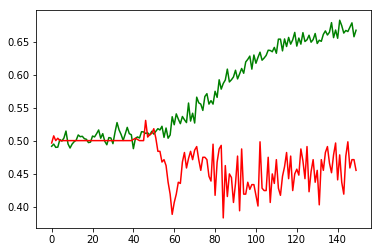

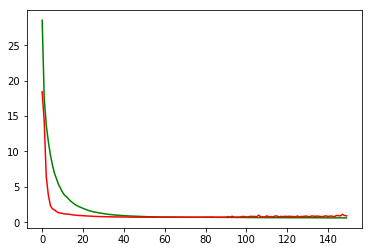

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[15.171749140745328, 8.079203018435726, 5.129719758475268, 3.648902143961118, 2.7390032292884072, 2.5309232811868925, 2.172986374961005, 2.01398781567444, 1.9159740525999187, 1.7765666297924372, 1.685646931330363, 1.6448998083303004, 1.5717422542748627, 1.5289770857787426, 1.4605684773421581, 1.4061043711356174, 1.3633974775855924, 1.3121916828332123, 1.2693652194223286, 1.2375230038607563, 1.185673001371784, 1.1592880288759868, 1.1386713105955242, 1.1132642935823511, 1.0717259829426988, 1.0682773619522283, 1.0271580668143283, 1.0037061756039842, 0.9920701929080633, 0.9688345157069924, 0.9601031666920509, 0.9432502315368181, 0.9282619702963182, 0.9192577409155575, 0.9048185252848967, 0.8997027866634322, 0.8861970960358043, 0.8804892860812905, 0.8651764304549606, 0.8586592085567522, 0.8541647026568283, 0.843508928646276, 0.8388342452637944, 0.8288537904068276, 0.8245186923462667, 0.8225380447175767, 0.8191711483178316, 0.8118038258434813, 0.8046810045654391, 0.8036833089074971, 0.798954

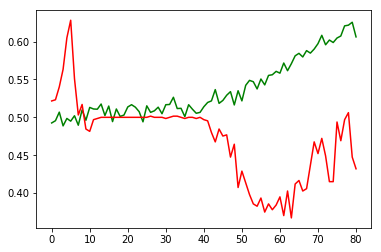

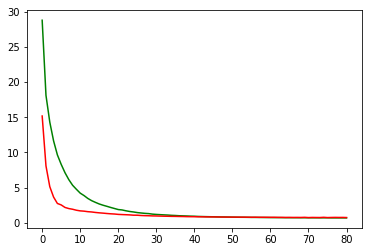

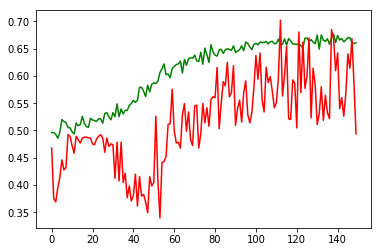

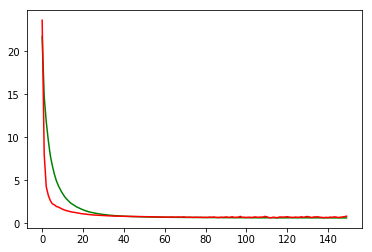

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[9.086769235399034, 3.7860388607449003, 2.5419516944885254, 1.9978506263097127, 1.6829625288645427, 1.5631122001012165, 1.4125270960066054, 1.298627750608656, 1.2019479049576653, 1.126628076500363, 1.066528040568034, 1.037279139359792, 1.0013937611050077, 0.9614420668284098, 0.9391583093007405, 0.9215343493885464, 0.9045138178931342, 0.859740006128947, 0.8409093096521165, 0.8195929940541585, 0.8164510122934977, 0.8142941048410204, 0.7966524410247803, 0.7899671239323086, 0.7734300014707777, 0.7644728983773126, 0.7577868639098273, 0.7659328126907349, 0.7481520811716715, 0.7436706190639072, 0.7390727972984314, 0.7468459121386211, 0.734723334842258, 0.7332191284497579, 0.7333443972799513, 0.7295509794023302, 0.723397793504927, 0.7226877819167243, 0.7197029678026835, 0.7176275987095303, 0.7163788368966845, 0.7165630168384975, 0.7144871478610568, 0.7137224732504951, 0.7129663353496127, 0.7118055650922988, 0.7101917820506626, 0.7083707960446676, 0.7079130951563517, 0.707434769736396, 0.709024

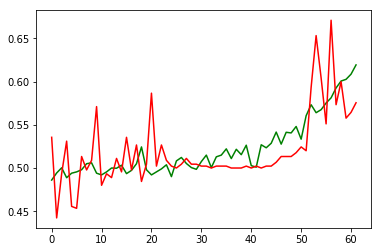

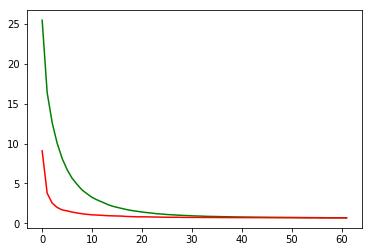

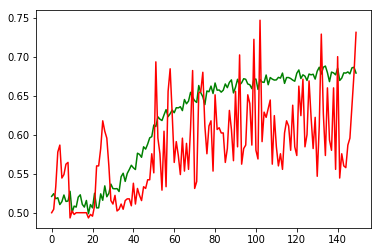

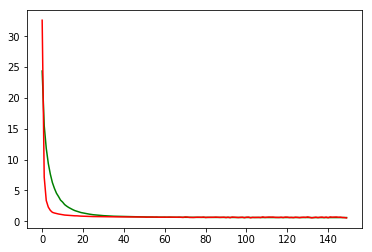

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[9.67876128670123, 4.011755153429594, 2.7565371835832115, 2.215383480778701, 1.8913742835573155, 1.684578457324625, 1.5621004198952544, 1.4471761447062594, 1.3494099031249396, 1.270231213072221, 1.2260714975192393, 1.1630188003718425, 1.1285886850288447, 1.0616847238094687, 1.0304645707281372, 0.9831213831043929, 0.9481597757167953, 0.9228759708164407, 0.9209880425775652, 0.8769967899048071, 0.8591553174334464, 0.8400635500606015, 0.8331699096899239, 0.8181838903495734, 0.8023704311830534, 0.7928519364741209, 0.7877723844788915, 0.7767354532969084, 0.7673194892972494, 0.765748001688676, 0.7598693563783769, 0.7501631241908177, 0.7470906038078473, 0.74076802181683, 0.7366992869823099, 0.7362000672079676, 0.730719322780911, 0.728337690555792, 0.7216644634445795, 0.7165899392512205, 0.7097417660754362, 0.7030763750453647, 0.6954641723804337, 0.6854806066417009, 0.6722972783253347, 0.6539725455448782, 0.6390052026124309, 0.6419933408284358, 0.6318091681535295, 0.6113148498878205, 0.60953530

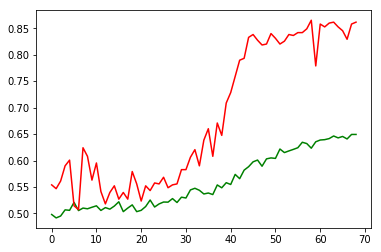

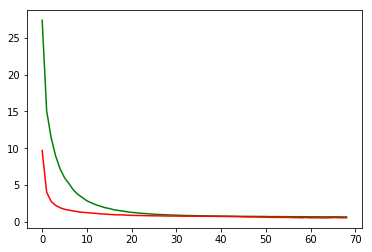

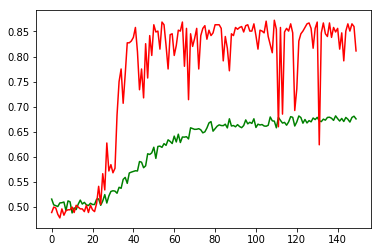

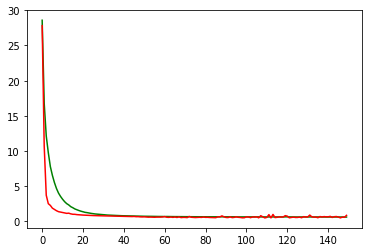

working on d,u and l 0.5 40 0.05
---------------------------------------------------------
---------------------------------------------------------


/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[201.03063092912947, 204.06609845842635, 136.94600459507532, 59.97434092930385, 35.39785445077079, 24.765367289951868, 20.020849800109865, 16.654139723096574, 13.262033830370221, 11.608588695526123, 10.31415741784232, 9.009500660215105, 8.162866142817906, 7.816889790126256, 6.97082405090332, 6.4570907252175465, 6.109863935198103, 5.718811518805367, 5.408407872063773, 5.017641401290893, 4.8702150821685795, 4.620417594909668, 4.370850661822728, 4.113992503711155, 3.9409568309783936, 3.8925854682922365, 3.687174047742571, 3.3501272916793825, 3.295377768789019, 3.1141982316970824, 2.9998471805027553, 2.8591796227863857, 2.6851483821868896, 2.6114631039755687, 2.502738734654018, 2.3861564057213918, 2.268462027822222, 2.3646003212247577, 2.1501898424965993, 2.1059466396059308, 1.9813796758651734, 2.0198143482208253, 1.873317629950387, 1.7940378972462245, 1.7374783549989974, 1.6838919367109026, 1.6444943428039551, 1.5880964960370745, 1.5733724083219256, 1.5294685244560242, 1.4883480429649354,

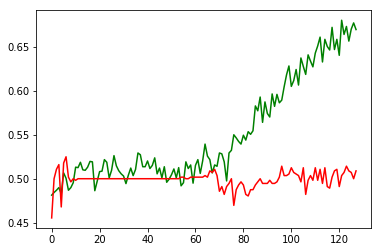

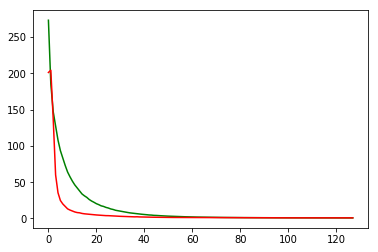

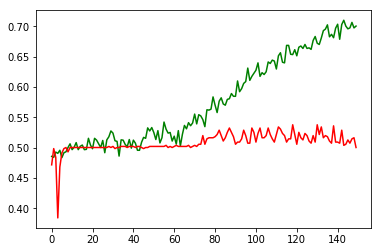

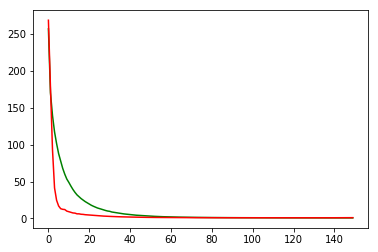

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[413.85310987711915, 347.8807778300544, 120.77554481907895, 39.52256154048781, 27.505292251525137, 18.41515713278581, 12.483028821134374, 10.703705065646153, 8.98078238529715, 7.837606074838986, 6.931161258867395, 6.324540493459354, 5.571648252155134, 5.33747046582612, 5.078713656437059, 4.696920068640458, 4.556388749767412, 4.269819188214507, 3.9015473103233678, 3.6728064666392832, 3.451937179333768, 3.280192576921903, 3.144309803541855, 2.949005974449127, 2.7495236975943995, 2.7660685618396714, 2.5371905097111997, 2.409274088708978, 2.2644763190736654, 2.166938354129251, 2.0714838499964974, 1.9829865317595632, 1.897047792369055, 1.7938519914140585, 1.7216020851482747, 1.6672259390595472, 1.6144365912024308, 1.5684720079908487, 1.5405007706962617, 1.4810458223829386, 1.4191067817240108, 1.3792403830207793, 1.3640840700280812, 1.3093451980637152, 1.2961055469899043, 1.2704539945733693, 1.2380656332139544, 1.1987536320319543, 1.1748404290512022, 1.1534148184394064, 1.1350401297271975, 1

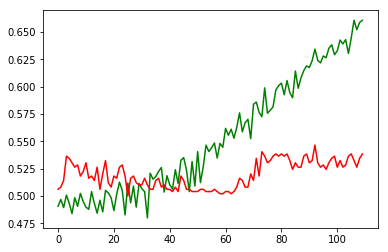

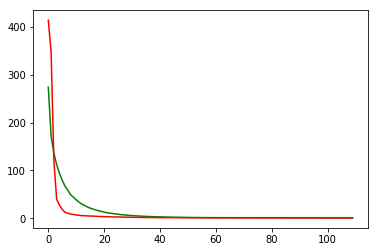

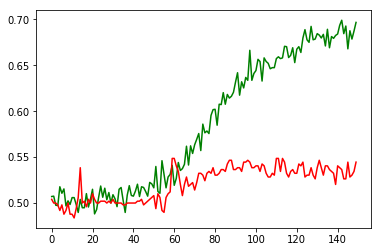

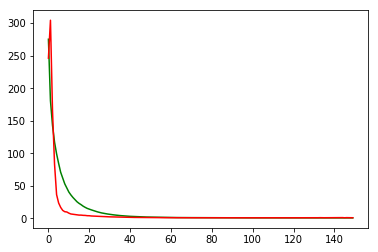

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[295.9857517614261, 153.4818879137831, 47.05200438723237, 25.26298533966395, 16.927455840127994, 12.69095684561058, 8.949070568119145, 8.560786890208936, 7.10681678241771, 6.052835440377466, 5.558256891229953, 5.035070476118839, 5.011322086898859, 4.353541153863018, 4.055358771382687, 3.701396118002248, 3.4503366245689806, 3.194487343195974, 3.039324479843305, 2.8019116699480406, 2.692779026737282, 2.454054355621338, 2.3415359336116253, 2.307130066926729, 2.077191704877447, 1.9706984702430477, 1.9328912500870357, 1.7885930516659567, 1.6914577094656467, 1.610828658303629, 1.5373155767306523, 1.47726221506346, 1.438912310970389, 1.3686441609145072, 1.328330528865222, 1.2783419100386142, 1.2413550460381628, 1.1963181248210397, 1.1629550915332478, 1.1319302049354525, 1.1182925681775227, 1.0764556344235416, 1.0546647583534572, 1.0412794540935475, 1.0195095838192139, 0.9972231788325396, 0.9871036995619212, 0.9815841162247778, 0.9616497118120159, 0.9480459201637158, 0.9442880844381312, 0.9309

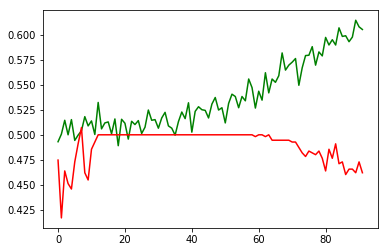

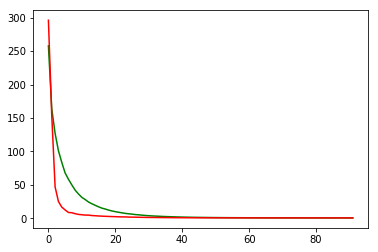

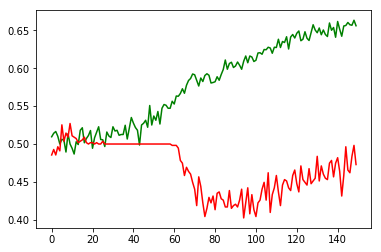

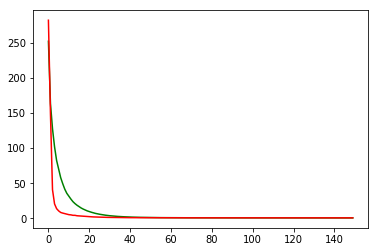

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[258.3979404590748, 73.83283587443975, 26.794925736792294, 19.06013058585885, 14.275326019451942, 12.564617823671412, 9.99945577427193, 9.057779942029788, 8.02827141020033, 7.3694571815891035, 6.684157771828734, 6.198209469701037, 5.8102215425467785, 5.419874027923301, 4.934971403928451, 4.5474357435732715, 4.195163752561734, 3.959096832775775, 3.6651097550804232, 3.4281643879266435, 3.171967230461262, 2.9871014194724, 2.811489626213356, 2.6418940432277727, 2.501526012096876, 2.335349470744898, 2.2077139321668646, 2.0900736075860484, 1.9888438015808294, 1.880035134009373, 1.8092783947049835, 1.7033330547956773, 1.658472411426497, 1.588791255597715, 1.5286266016371457, 1.488130392851653, 1.4369555873635373, 1.3965143487777238, 1.3516985759323026, 1.3200706964657631, 1.286599925270787, 1.2652523031941167, 1.2401536695751143, 1.2075396481855416, 1.1938339295210663, 1.1702946321463878, 1.1581554567372356, 1.1412661060874845, 1.1115829444225924, 1.1081855275012829, 1.0919421359344765, 1.078

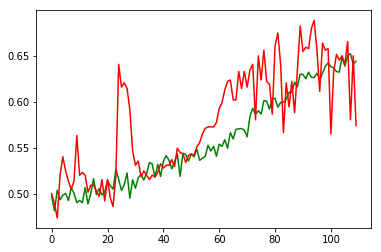

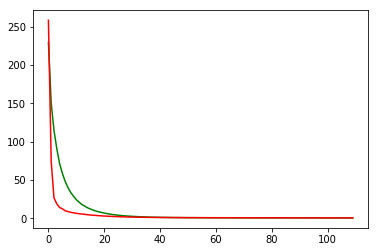

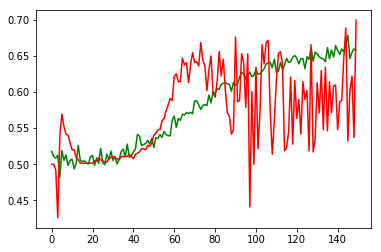

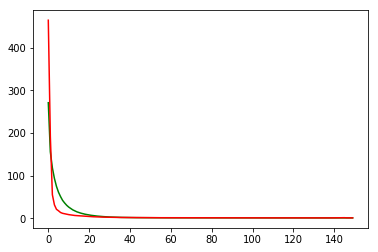

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[284.5312102593316, 49.63068172878689, 19.977995037502712, 12.113209533691407, 8.964296792348225, 7.377193885379367, 6.178803187476264, 5.217140605714586, 4.343215005662707, 3.8489310783810087, 3.5183127244313557, 3.1908816666073267, 2.8252163865831164, 2.53378765212165, 2.3198431491851808, 2.1553901598188614, 2.009862393273248, 1.819435862965054, 1.6992923625310261, 1.6085459550221761, 1.5129571782218085, 1.4246972635057238, 1.3565699479315017, 1.2813046587838066, 1.2312169496218364, 1.2010177347395155, 1.1545472727881538, 1.1342767781681484, 1.0882011408276029, 1.0672623666127523, 1.0391728814442953, 1.0207068101565042, 0.9976088439093695, 0.9854928421974182, 0.9675160752402412, 0.9578899825943841, 0.9455072217517428, 0.9348398571544223, 0.9203368269072638, 0.9139495227071974, 0.9101274961895413, 0.8992833034197489, 0.8912157636218601, 0.8870832141240438, 0.8748283998171489, 0.8748548934194776, 0.8604105393091838, 0.8667520123057896, 0.8553330455885993, 0.849773621559143, 0.845110690

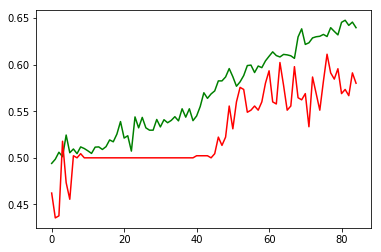

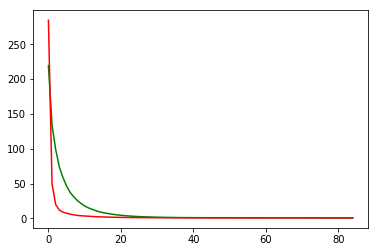

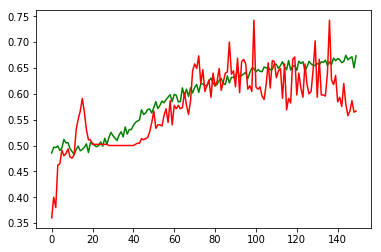

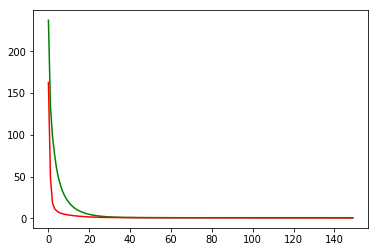

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[213.18989486145458, 51.195853638134416, 22.128043078690123, 13.239556432627946, 10.230174843355906, 8.543318004059277, 6.735362459429734, 5.980843828736449, 5.189086894337222, 4.639353684384188, 4.173796410183255, 3.7145399995845, 3.4507008953917797, 3.0336142889887308, 2.810502707529411, 2.591451082298224, 2.3719220470181472, 2.2003885387516706, 2.0410021483469354, 1.925921192272104, 1.8080824129015423, 1.7330274954974223, 1.6308494986390039, 1.5457211544187806, 1.4910306407393312, 1.4392394457789635, 1.3636812417627238, 1.3359186687915445, 1.2859663487338333, 1.2480010446027028, 1.2027834769633177, 1.1714798186322768, 1.1464903024460773, 1.125705280749918, 1.1012266213945348, 1.0805393869070699, 1.0539237685340772, 1.0441651601585553, 1.0320511203018023, 1.0106857633419175, 1.000375843305382, 0.9825204850958406, 0.9771967341573976, 0.9599041900188803, 0.9442355598477151, 0.9365855884208953, 0.9164004463086025, 0.8978098609464632, 0.8809404497523959, 0.8679032381489981, 0.85860341744

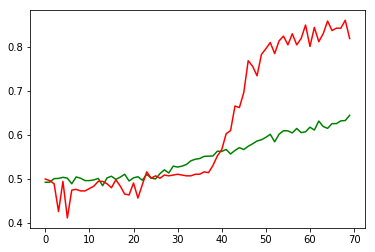

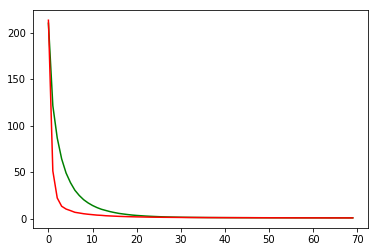

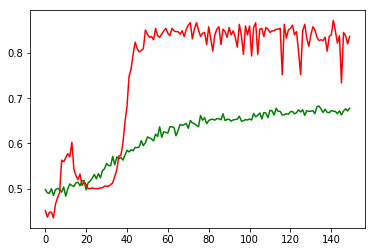

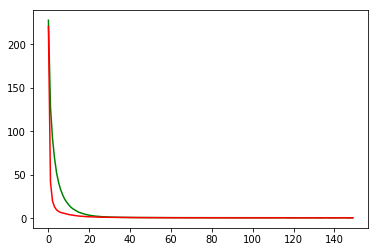

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
BEST FOT THIS MODEL VALIDATION ACCURACY: 0.5803172277811757
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
working on d,u and l 0.5 40 0.01
---------------------------------------------------------
---------------------------------------------------------


/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[58.230804552350726, 46.611401258196146, 25.291509437561036, 11.70658200127738, 7.6727708680289135, 4.8563597270420615, 4.105269071034023, 3.1674268415996005, 3.0740996837615966, 2.5745465551103863, 2.4772327865873063, 2.2748213529586794, 2.124224090576172, 2.014361660821097, 1.8772805827004568, 1.793337825366429, 1.6886978694370816, 1.6425736836024694, 1.5939042057309831, 1.547363155228751, 1.462012835911342, 1.46055166721344, 1.3664308275495256, 1.3546735831669399, 1.3037857396262034, 1.2769148996898105, 1.2272889699254717, 1.193283326285226, 1.1624686343329294, 1.140986921106066, 1.1189439807619368, 1.0867014237812587, 1.0685579776763916, 1.04884957415717, 1.034557546888079, 1.019529972757612, 0.9971164567129952, 0.9763626677649362, 0.9602037991796221, 0.9470797095979963, 0.932373286996569, 0.9203126668930054, 0.9090882658958435, 0.8948334727968489, 0.8878003341811044, 0.8761474643434797, 0.86803719997406, 0.8589571680341448, 0.8537962027958461, 0.8442543063844953, 0.844872864655085

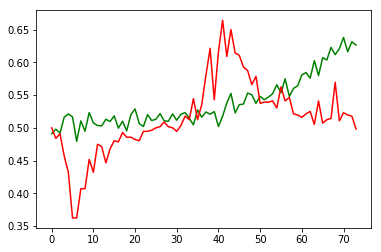

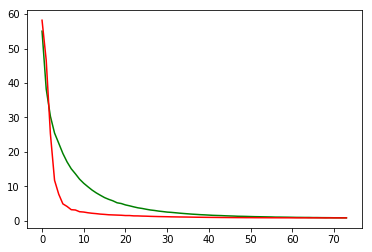

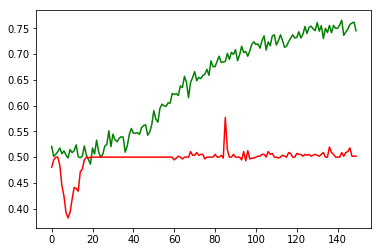

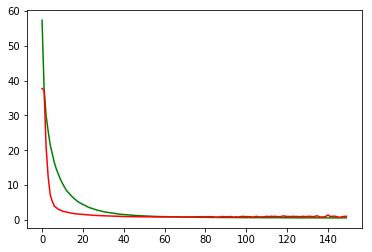

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[60.20834007726507, 44.814044102966065, 21.41450825586975, 10.102392405150873, 6.388923166251859, 4.851975543296289, 3.6686767074260636, 2.971047154322327, 2.613684938021517, 2.272817509377051, 2.1361189293957916, 1.926134155346797, 1.8076475535327123, 1.7798871535521288, 1.645632601459982, 1.5861256199809703, 1.5366711809567595, 1.4919205860570375, 1.4386378874180288, 1.3692661210110313, 1.3257869805401636, 1.2996236312727214, 1.2517096865997623, 1.2133045563331017, 1.1780224348369397, 1.1398361303545685, 1.1145267409351673, 1.0896011875708576, 1.0674471005737058, 1.0494344504738626, 1.0202711359692005, 0.9952862470256172, 0.98168485512135, 0.963645352043121, 0.9416889963362381, 0.9247530030335492, 0.9119321696671397, 0.8995486830892833, 0.8876564280706861, 0.8723009332471531, 0.8685266875062394, 0.858178725850727, 0.8506096661814794, 0.8451639247326715, 0.8380855367733882, 0.8334881516120695, 0.8327051992358466, 0.8253662899920815, 0.8261258539400602, 0.8249212942625347, 0.8157211865

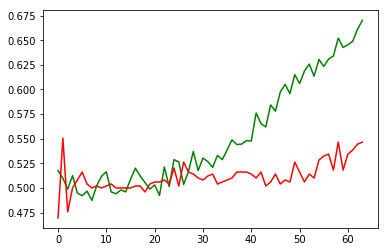

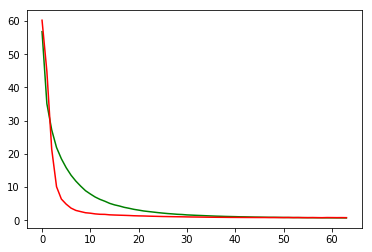

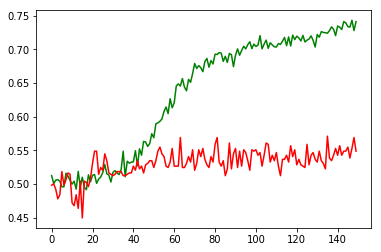

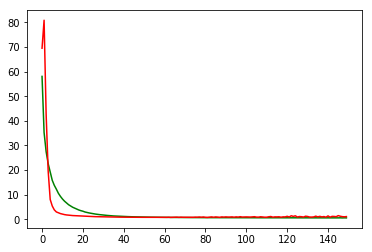

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[83.53702103790394, 32.46449229175003, 11.533531922295635, 5.764374869825177, 3.7127796166209968, 2.5982817622298366, 2.3569998117130155, 2.0129749624307407, 1.768420208232067, 1.700941876383895, 1.568026176858895, 1.474982161384197, 1.3713125870546279, 1.3172033758370023, 1.274873359323839, 1.2283993501095134, 1.1704444930441542, 1.1228774880674341, 1.094218381045097, 1.0517453009040778, 1.0202677335980137, 0.9939263465172117, 0.9822245567283906, 0.9471333939245892, 0.9137973404533166, 0.8980613447698875, 0.8820148463283635, 0.8730591434434003, 0.8513696344320525, 0.8371784050111736, 0.8248677189169378, 0.8161720048219289, 0.8064676264993551, 0.8006475012655293, 0.7940238823959543, 0.7858823290370431, 0.7800664512259005, 0.7753253064861366, 0.7733426264046762, 0.770841830904303, 0.7638981017395047, 0.7644670594900523, 0.7617529919001169, 0.7624180415907491, 0.7630571591724988, 0.763787852297621, 0.7586931276407483, 0.770051677519664, 0.7569351669683353, 0.7601131119022301, 0.757682475

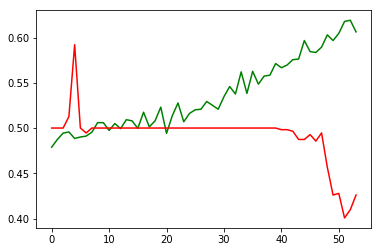

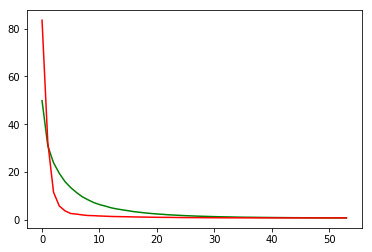

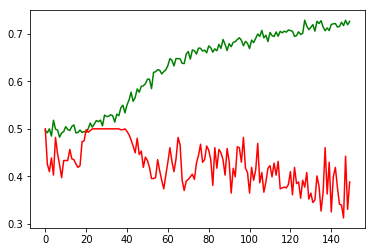

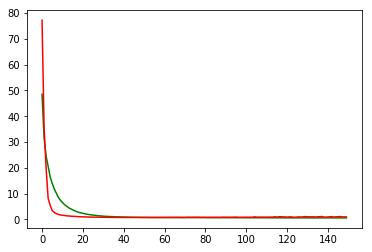

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[80.49611848666345, 26.781432297494675, 10.824760650411065, 7.185722172996144, 5.014032068811817, 4.293490295792803, 3.381560884140156, 2.967692234633881, 2.669064746962653, 2.5014534997351374, 2.3334981865353055, 2.1187518614309804, 1.9578282376866283, 1.8690595832871801, 1.751236515280641, 1.6579801822886056, 1.5859176104451402, 1.5286523449568101, 1.4459777216852447, 1.3860147521819597, 1.3377521133717196, 1.2880839815846197, 1.2607921950611067, 1.2104833619094189, 1.1803676861303825, 1.1538556711173351, 1.118829502735609, 1.085081723737128, 1.063048177295261, 1.0361402814770921, 1.0164425498173562, 0.9979623776895029, 0.9876071082221137, 0.9658944856973342, 0.9550862165144932, 0.9408912835297761, 0.9221603502461939, 0.909961082317211, 0.9026646268220595, 0.8862199717097812, 0.8784098279328993, 0.8665649920334051, 0.8608182705478904, 0.8562916863111802, 0.8523647233291909, 0.8457601762112276, 0.8390728860725591, 0.8359518934179235, 0.8343714092984612, 0.8366265495618185, 0.828276511

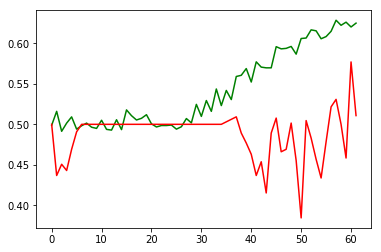

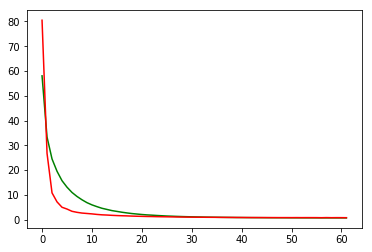

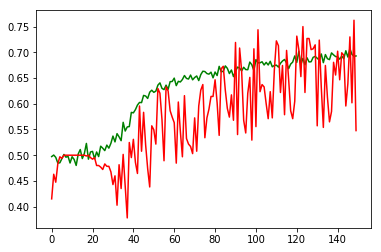

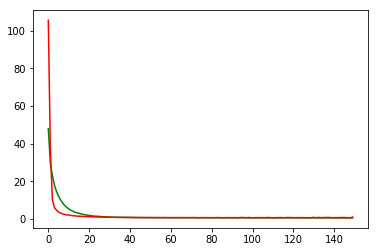

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[72.48159079657661, 14.297490749359131, 5.23124787012736, 3.4934497918023, 2.522626232041253, 2.054264415105184, 1.8806545485390558, 1.6853817049662272, 1.500488953060574, 1.408873192469279, 1.3204007127549913, 1.2593816929393344, 1.1745817671881782, 1.1210005384021335, 1.064871563911438, 1.0279239858521356, 0.9856117545233832, 0.955397351053026, 0.9206953016916911, 0.896685733265347, 0.8751468536588881, 0.8556274753146701, 0.8398987833658854, 0.8303493661350674, 0.8169947025511, 0.8054294726583693, 0.7968827332390679, 0.7863220387034946, 0.7836287273301019, 0.7777371305889553, 0.7696890592575073, 0.7666069255934821, 0.7603089170985752, 0.7567400172021654, 0.7526646155781216, 0.7456900654898749, 0.7477309754159716, 0.7348867331610786, 0.733291085296207, 0.7324735095765855, 0.7233536365297105, 0.7060505670971341, 0.694834414323171, 0.7285807797643873, 0.7038038592868381, 0.7247119614813062, 0.6950368131531609, 0.6972649208704631]


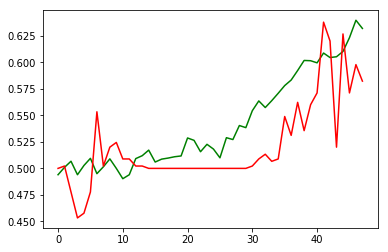

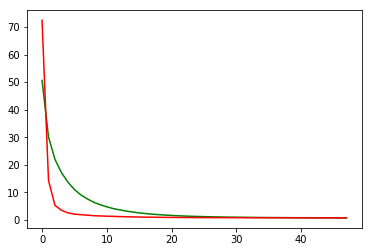

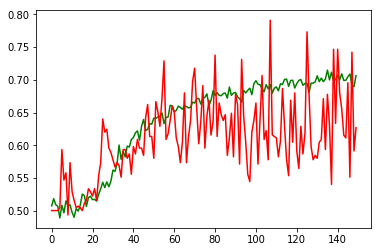

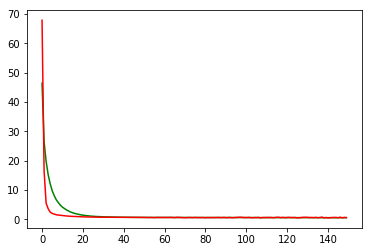

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[40.19383083316062, 6.715140656601611, 4.107282027923803, 3.475564543291819, 2.8001544166811936, 2.3814352819387863, 2.133777084110452, 1.9041755593937935, 1.7310562819885693, 1.6469804991921075, 1.532784367636811, 1.406759504791644, 1.3332752456767953, 1.247042438109144, 1.1806345732092, 1.1274908287919683, 1.0913998857676555, 1.0417772197037292, 1.0097712282654192, 0.9806559703332914, 0.9503104249350458, 0.9244582361454586, 0.9004511425821043, 0.8828498348057698, 0.8659694027557647, 0.8533136270029081, 0.8356875086859833, 0.8208078021625821, 0.8039718025879894, 0.7886681681056674, 0.7748999316915334, 0.761711510394117, 0.7513618730812621, 0.7356030743756741, 0.7169637294124356, 0.6974234555265029, 0.6790835887408085, 0.6750149924120457, 0.6603301386181399, 0.640157968449078, 0.6401743369994404, 0.6269363842422156, 0.6071708601155728, 0.5984987123407048, 0.5883455761045003, 0.5919124561248066, 0.5900047747351282, 0.5742200904612919, 0.589276481017792, 0.5751577662907058, 0.57552130874

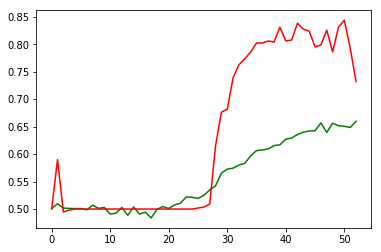

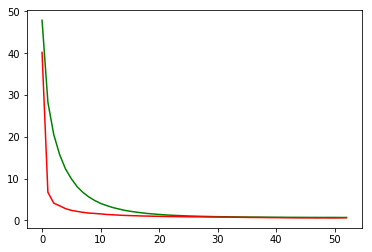

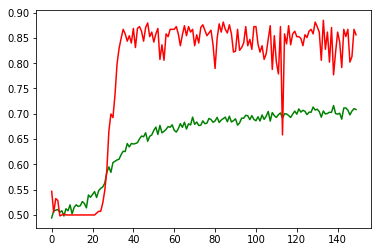

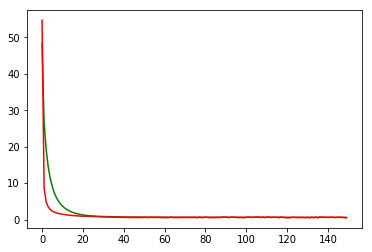

working on d,u and l 0.5 80 0.05
---------------------------------------------------------
---------------------------------------------------------


/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[627.5659371512277, 560.3667192731585, 346.8634512765067, 127.22122181483678, 69.84406106131418, 47.67833622523717, 33.43539458683559, 25.544567026410785, 20.164615876334054, 16.668158967154366, 14.347253581455776, 12.667443902151925, 11.458008302961076, 11.238398906162807, 10.120662661961147, 8.594291067123413, 8.177670962469918, 7.681337084089007, 6.849578584943499, 6.470471613747733, 6.235591343470982, 5.715404960087367, 5.465928418295724, 5.082566002437047, 4.7330125740596225, 4.483740615844726, 4.271765320641654, 3.988691180092948, 3.788038751057216, 3.5458858864648, 3.4584956407546996, 3.216116568020412, 3.082516254697527, 2.9430703026907783, 2.841265957696097, 2.6529942580631802, 2.605143564088004, 2.4642746891294207, 2.352883999688285, 2.2774726288659233, 2.193873487200056, 2.087188833100455, 2.0308665445872713, 1.961358962740217, 1.9027955293655396, 1.8513917582375663, 1.7831906931740897, 1.7257670743124827, 1.6934677839279175, 1.6637114933558872, 1.6149176631655011, 1.5632633

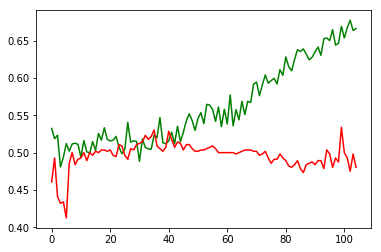

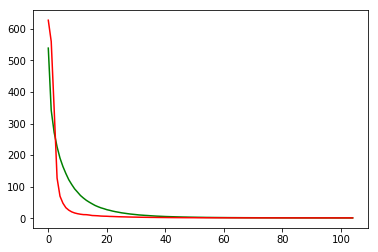

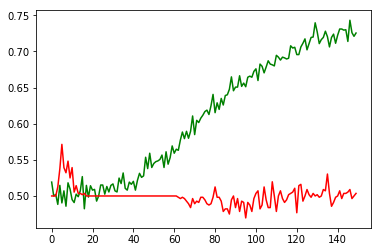

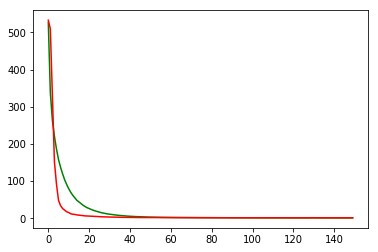

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[656.9767003850899, 405.3152043269231, 92.40162683401996, 43.641582689787214, 35.22509157126732, 25.19065733380646, 19.620682434514467, 16.218927896939793, 13.748430591845802, 11.522642382726014, 10.458630249085214, 9.563021524715037, 8.022297878497042, 7.465750414350254, 6.88197940563866, 6.313029229399646, 5.905152010048932, 5.314792579002226, 4.971829924023586, 4.743831207877712, 4.344639554197489, 4.107799741420669, 3.881686365073509, 3.5632196640678746, 3.3587787527787056, 3.157076358795166, 2.9644506209292394, 2.818955924346862, 2.704811941756893, 2.5191309384488867, 2.390473778913861, 2.3089159432693047, 2.1936807941328658, 2.113015771394799, 1.9936826576588125, 1.9402258743641347, 1.8621389170889913, 1.7834485696877544, 1.7159301578274622, 1.7076453351781435, 1.6208311642712427, 1.571117733654223, 1.5228576867686592, 1.4711208695824813, 1.4549856137650217, 1.3947052757749674, 1.3739891052246094, 1.3448147016015612, 1.326440610866315, 1.2988969758454605, 1.2715032366123276, 1.25

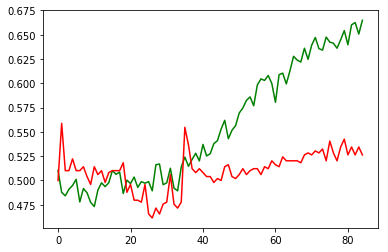

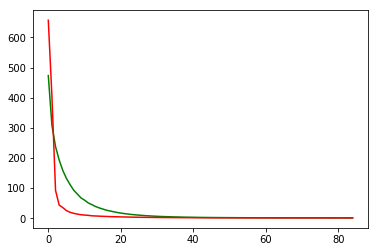

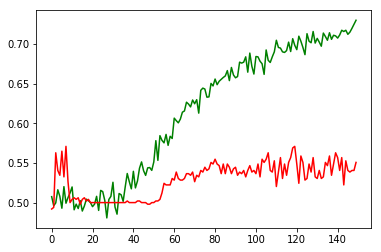

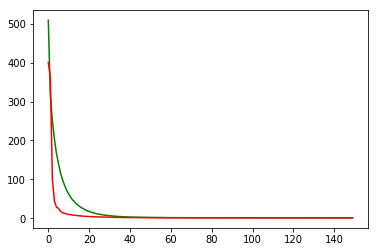

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[445.04849898686047, 105.0068733683562, 36.4916485603966, 25.849955872077803, 17.15664211851595, 14.837064698284713, 11.40764454211569, 8.999510351070859, 7.653127369037174, 6.583773050067227, 6.391137710116831, 5.396712468419264, 4.7781569708125256, 4.30572354664441, 3.9662461745609874, 3.6352244744662343, 3.366437103774143, 3.0094327978278756, 2.8727555954929724, 2.6134235549059155, 2.4046704764830937, 2.22848470718852, 2.0725849135257706, 1.964116686087653, 1.8824707411686867, 1.7353262847511346, 1.6674783967892617, 1.5906430652855965, 1.51451302693639, 1.4594367213197563, 1.3925904728445335, 1.3495268940064882, 1.3022833533235405, 1.2694651191845698, 1.2318781777839798, 1.194565597424008, 1.1814702411420939, 1.1537523084599188, 1.1302382853487338, 1.117628810853304, 1.1013066217787428, 1.0821448454788016, 1.0678086310947845, 1.0555487460177728, 1.0424245643271437, 1.0363900157949124, 1.029569292757055, 1.020452448822531, 1.0117174225593732, 1.0121867172554513, 1.0078131788904485, 1

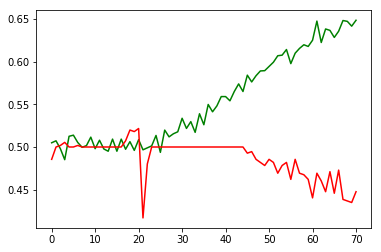

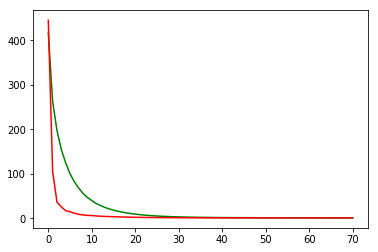

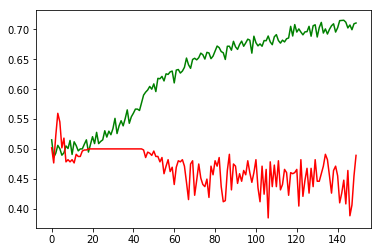

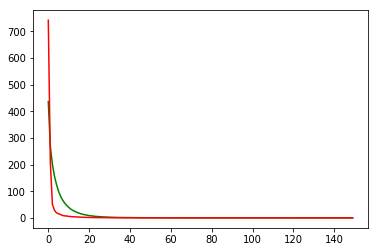

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[435.9203932726825, 136.8315594225754, 52.23515958550536, 37.57920589270415, 27.45912840336929, 21.188075171576607, 17.452327726799766, 14.921819502924695, 13.204755532888719, 11.516858047909206, 10.15327282452289, 9.20413033461865, 8.741284725106793, 7.85267287566338, 7.203321513570385, 6.5682653814186285, 6.102184498015745, 5.516105499532488, 5.21352908714318, 4.8350200962137295, 4.444926228052304, 4.146648596834253, 3.939541781390155, 3.7056145822560347, 3.4400708351606206, 3.262419079556877, 3.0867840905248385, 2.907105309727751, 2.8052487564675603, 2.6614363031622803, 2.5756219537169844, 2.4568885233667164, 2.375492203382798, 2.28968346118927, 2.2030196057425604, 2.1367128631215038, 2.0962126394848766, 2.00456741783354, 1.9685245980451136, 1.9033967911461254, 1.8675483443118908, 1.8391362185831424, 1.7923684981134202, 1.7538713776035073, 1.704639137527089, 1.6866235872845592, 1.6317779164255402, 1.6173074149791105, 1.598306432918266, 1.5655121840076682, 1.5472539280667716, 1.52389

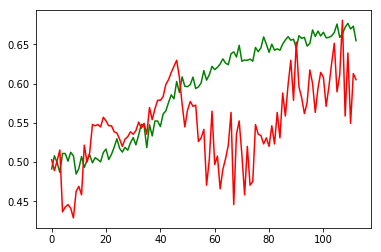

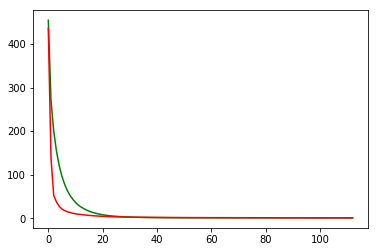

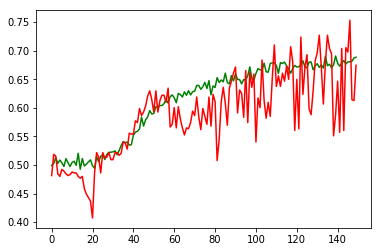

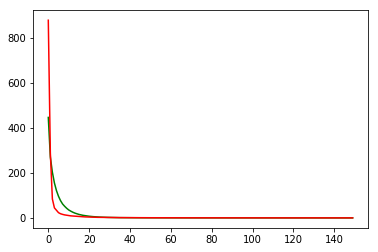

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[451.26833163791235, 106.87919292873806, 37.73961582607693, 20.72875491248237, 13.219784261915418, 10.215048838721382, 8.378250969780815, 6.800899749332004, 6.40421517584059, 5.271579979790582, 4.67436267958747, 4.111063550313314, 3.777684472401937, 3.308490451176961, 3.0082400523291692, 2.702359364297655, 2.493397691514757, 2.2897786792119343, 2.1545656183030872, 1.9537113767200047, 1.816431638929579, 1.700026282734341, 1.6031370051701863, 1.5326729006237454, 1.4574022836155363, 1.3929211354255677, 1.3423086272345648, 1.3021627558602227, 1.2561306606398688, 1.2266968454254998, 1.1970081994268629, 1.1715584641032748, 1.1412035348680285, 1.1168322618802389, 1.0995090754826864, 1.0839986962742276, 1.0632886974016826, 1.0513366219732496, 1.0394319232304892, 1.0246448964542814, 1.0130723484357198, 1.0098893120553758, 0.9930592775344849, 0.9901794007089403, 0.9723629819022285, 0.960261165301005, 0.9632170150015089, 0.9623323549164666, 0.9419088239139981, 0.9378823026021321, 0.91884444183773

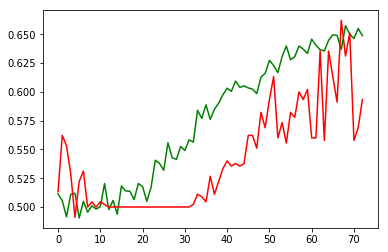

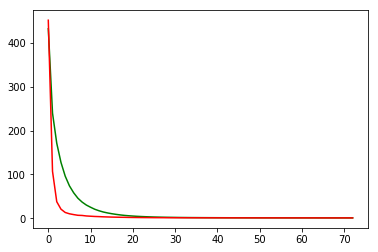

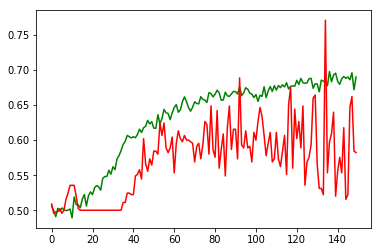

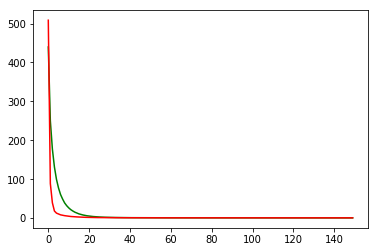

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[376.55317742876014, 56.55051378208956, 30.20175357516721, 19.766341188828722, 14.583293681522067, 11.711679079549775, 10.224023856705042, 8.68688040843113, 7.662559697953917, 6.74191903896469, 6.123440610419075, 5.466451264971452, 4.926759321912587, 4.399070026205598, 3.908258767436734, 3.538062298040596, 3.2334042315860447, 2.9368948970767232, 2.665137344127079, 2.4485839056454117, 2.2756539921966388, 2.127086065227179, 1.9922178246134477, 1.8610135668473278, 1.7475817169216896, 1.67220303823622, 1.6007248982251119, 1.52346151595493, 1.4635640918779715, 1.4197823683992565, 1.3689559903933848, 1.3235572636556283, 1.276223422383233, 1.224362359630118, 1.194365139487836, 1.157497259781515, 1.1289478094457723, 1.1090154300490729, 1.0721477218669095, 1.0563288798435129, 1.0378568995770792, 1.0062059112589994, 0.994462964346083, 0.9628629457178733, 0.9617429199836237, 0.9377081960225276, 0.9259743506102254, 0.9086330237148477, 0.8909948069414646, 0.8846021770573348, 0.87299688471307, 0.858

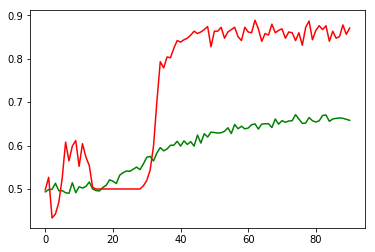

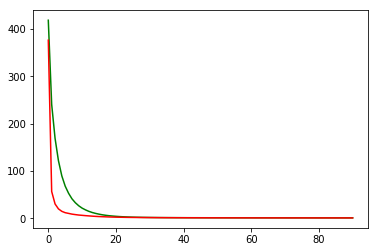

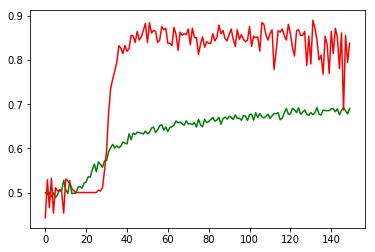

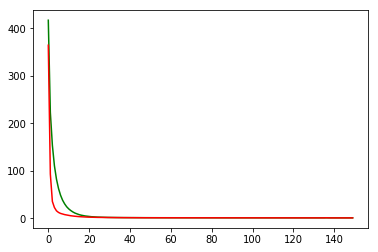

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
BEST FOT THIS MODEL VALIDATION ACCURACY: 0.5871835936480883
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
working on d,u and l 0.5 80 0.01
---------------------------------------------------------
---------------------------------------------------------


/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[99.02247150966099, 67.90172402518137, 39.19428890773228, 24.6800719669887, 11.335242775508336, 8.496528339385986, 6.567255510602679, 5.086903735569545, 4.356340953281948, 3.8648758820125035, 3.2853130953652516, 3.1050690412521362, 2.8204178503581456, 2.5714720146996632, 2.4969902004514424, 2.2830328226089476, 2.2107418809618267, 2.109006782940456, 1.951844028064183, 1.901779181616647, 1.8303929328918458, 1.7095236199242727, 1.6555694716317313, 1.600972706930978, 1.5411543812070574, 1.4846038852419172, 1.44205869947161, 1.4048196145466396, 1.3466083305222647, 1.3203047718320573, 1.268711463042668, 1.2448753901890346, 1.2136887533324106, 1.170181165422712, 1.143159362248012, 1.1272790449006216, 1.0991236482347762, 1.068399155139923, 1.0474032316889081, 1.0358555623463221, 1.0042500121252877, 0.9954780493463788, 0.9766208359173366, 0.9674665723528181, 0.9486776522227696, 0.9382168957165309, 0.9382594568388802, 0.9128734282084874, 0.9139056614467076, 0.9177169033459255, 0.9139905214309693

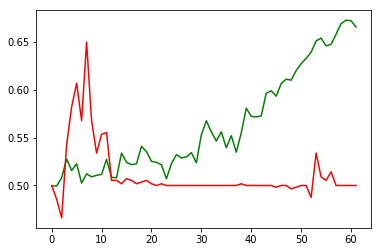

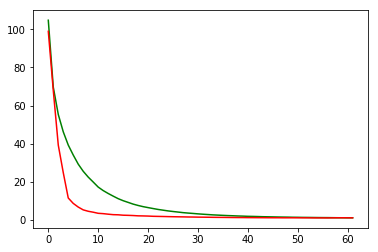

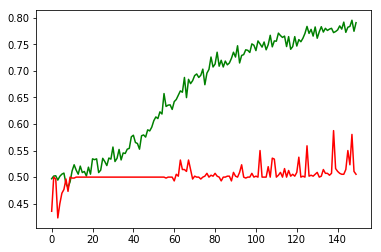

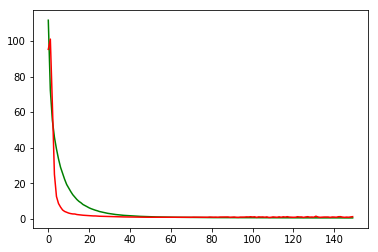

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[103.96297544409872, 73.35007220434274, 29.952759746597845, 12.33232113996498, 8.924590740126638, 5.164544607463636, 4.443046887393905, 3.7294202931979408, 3.2387941028425087, 2.691284249186033, 2.588741844964896, 2.2949610490065355, 2.061190740299611, 1.9860039056554015, 1.8020081162935326, 1.739746720202056, 1.5976893496416842, 1.5141797500100695, 1.4708338903512066, 1.3912793648870367, 1.345087860759936, 1.2810100915460934, 1.2326507346350173, 1.2073729429167774, 1.1688388928710691, 1.1245795531794127, 1.0966805933940749, 1.0748530732475312, 1.0463830360516846, 1.0211006475363666, 0.9950595732159943, 0.9782248165925987, 0.957091028149794, 0.9435843238946398, 0.9325236528508576, 0.9186614175074497, 0.911967718166861, 0.9004274078226282, 0.8975201044005421, 0.8834587702384362, 0.8787133167629783, 0.8687439780486258, 0.8840157042148142, 0.88496324432041, 0.8671953632281377, 0.8812084171453468, 0.8470975327105658, 0.8717070564567319, 0.8472970620340664, 0.8681303928738181, 0.84503447285

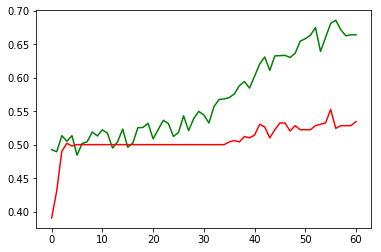

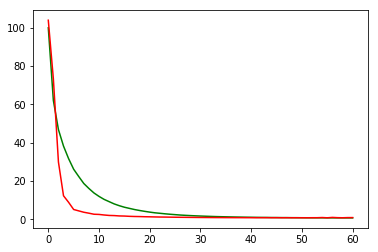

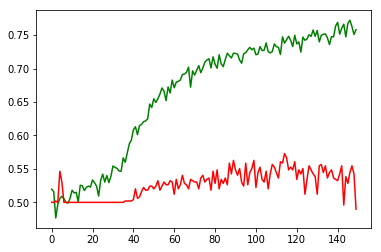

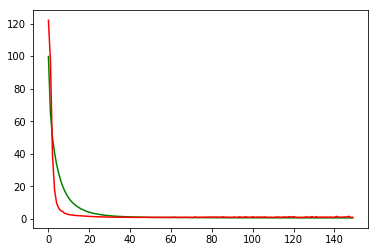

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[62.35216443030843, 25.936338114824537, 10.250616912807368, 5.968711008664073, 4.24648203057933, 3.4335245853727043, 3.014881529532615, 2.725803065816418, 2.1959215613478786, 1.9685426971972635, 1.889708660139504, 1.7563425027076087, 1.606538996799758, 1.4979889541326448, 1.4136784317691404, 1.3462951299515873, 1.2917370961891614, 1.2226838318879854, 1.2050635554299889, 1.1423793503954092, 1.0917588840322805, 1.061830670394622, 1.02084545968672, 0.9980966902812035, 0.9713489912477211, 0.9528407342597466, 0.9319400389271953, 0.9141511957998311, 0.9003718820289585, 0.8965327208222895, 0.8807302263669589, 0.8842539548443543, 0.8705389766486543, 0.8635681910635332, 0.8538683792744303, 0.8523773172271811, 0.8479396109116206, 0.8664572565994538, 0.8555189736913688, 0.8425041906239754, 0.8638805387682863, 0.8430205613697479, 0.8568146848506446, 0.8996218171791049, 0.8375835543505121, 0.8481709965729972, 0.8923487757947901, 0.8501373499309113, 0.8787658451266237, 0.8486530806613743]


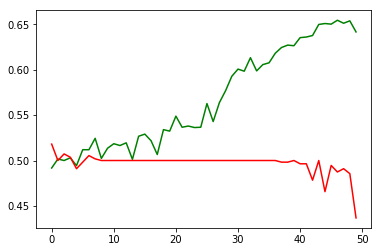

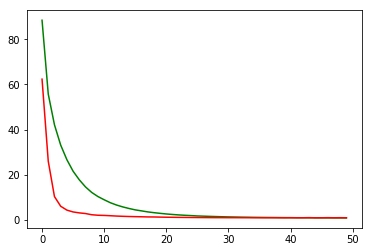

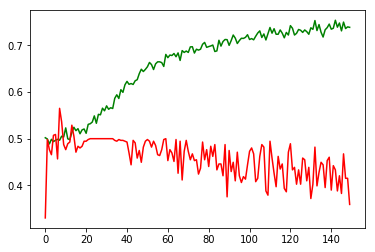

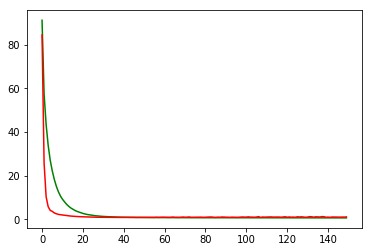

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[125.74395321033619, 31.99275228123606, 11.437546933138812, 7.930225175104024, 5.892948464111045, 4.776283779262025, 4.032234475200559, 3.5229665887208634, 3.1311936761126105, 2.943907715656139, 2.6938348993842984, 2.502478575264966, 2.2872260838379095, 2.128497575536186, 2.0095487465093167, 1.9254995312219785, 1.77434116454772, 1.688806661117224, 1.602328449855616, 1.5258665379182792, 1.45779945453008, 1.4164183441503548, 1.347629322681898, 1.3084741433461506, 1.2538822374226135, 1.2076708446314306, 1.1858871299543499, 1.152528229319019, 1.1127997504340277, 1.0946936283582522, 1.0727745419667092, 1.047980088510631, 1.0332942060482355, 1.019593032789819, 1.014302459028032, 0.9861157683678615, 0.9752284148593008, 0.9592664418397127, 0.9436212675071057, 0.9344204119694086, 0.9346659477846122, 0.9301233188605603, 0.9004543725355172, 0.9117393552521129, 0.8878762192196317, 0.889649107132429, 0.9321471158369088, 0.8697579753251723, 0.8920556086081045, 0.8589028561556781, 0.8588389820522733,

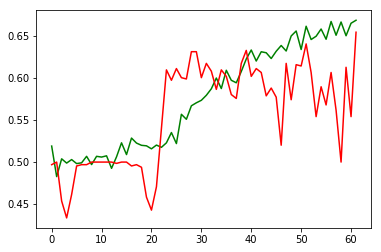

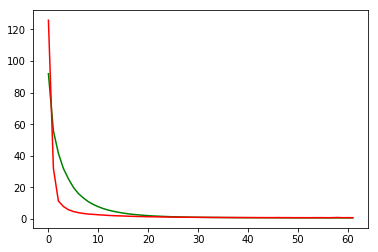

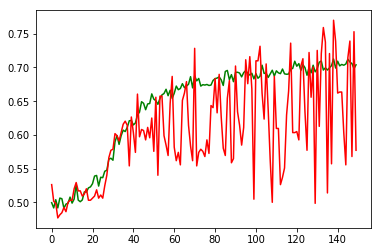

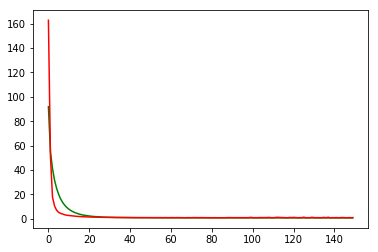

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[99.54855516221788, 15.97859375, 5.689644957648383, 4.0232343175676135, 3.1642094071706137, 2.7084541108873155, 2.201710432900323, 1.9775139909320407, 1.7673861005571154, 1.6631605143017238, 1.5032041194703845, 1.3910188677575852, 1.2976903629302978, 1.220684262646569, 1.15315213865704, 1.1008833331531949, 1.0534802990489536, 1.0037499478128222, 0.9809690867529975, 0.952282787958781, 0.9250540908177693, 0.9058192237218221, 0.891773562696245, 0.8667854324976603, 0.8525809746318394, 0.8456263176600138, 0.8271313627560933, 0.8165696130858527, 0.8237121674749587, 0.7790134358406067, 0.7754267708460489, 0.7734824517038134, 0.7737062864833408, 0.7095515603489346, 0.7488808915350172, 0.7392617419030931, 0.774223243660397, 0.7634071452087826, 0.7546707857979669]


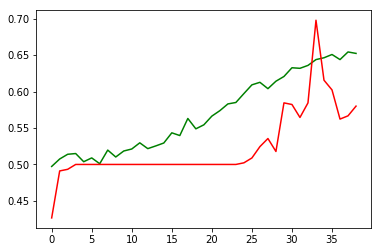

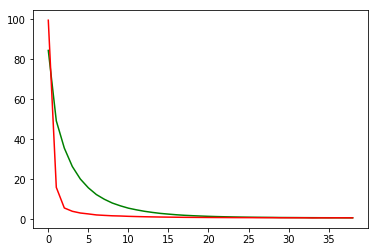

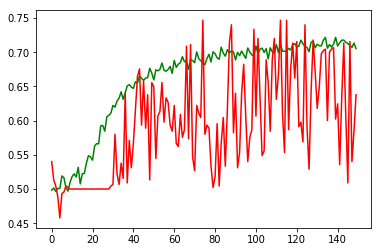

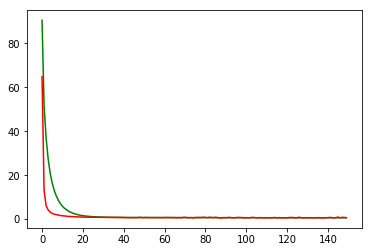

/home/andrea/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


[80.41438731186682, 11.401869022588937, 6.098050066035428, 4.247957524635809, 3.3424267280016013, 2.875299330237958, 2.520548764750254, 2.1713927838442135, 1.9549399708672393, 1.7762619136906357, 1.628650026355716, 1.5298375358684457, 1.418982460344438, 1.309860158309662, 1.2518886211964724, 1.1750492041917155, 1.1124263165666044, 1.071289216014121, 1.0288482745774359, 0.9963598525781425, 0.9603312440055738, 0.9277580710623762, 0.8941461628289531, 0.874874648859175, 0.8367463444634308, 0.8151410569389947, 0.7710191277291277, 0.7620516899678347, 0.7265819212515577, 0.7212727867442069, 0.7028381361378183, 0.6823595084732385, 0.7081336280424818, 0.6500511885546952, 0.6265645151515659, 0.6208150421115134, 0.6169014238625121, 0.6320453144663529, 0.615078724974351, 0.608086794829197, 0.6709895738594823, 0.5945235143462531, 0.6349195469197609, 0.5903263109193432, 0.5550410949068961, 0.6605946155760786, 0.5659789927571798, 0.5712996965689625, 0.6178932623039904, 0.6163011184699244]


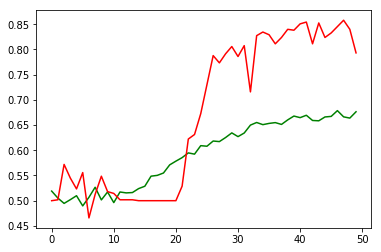

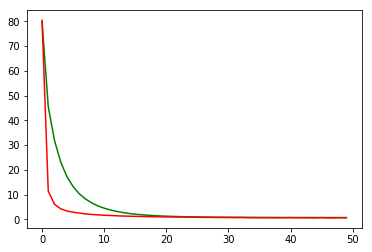

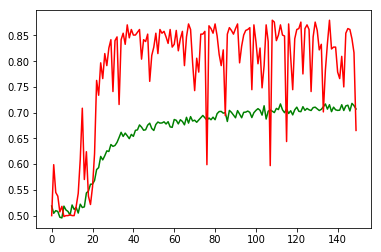

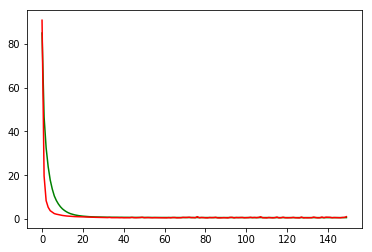

Test


TypeError: buildModel() missing 1 required positional argument: 'd'

In [4]:
o=0
accstocksresults=[]
f1stocksresults=[]
f1scoreresults=[]
aucresults=[]
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=0) 
early_stopping=EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
for price in prices:
    #print('New price[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]')
    
   
    print('Working on...',files[o])
    o+=1
    xtemp=price
    xtemp=np.nan_to_num(np.asarray(xtemp, dtype=float))
    xtemp=normalize(xtemp,axis=0,norm='max')
    #print(xtemp)
    accintime=[]
    trendwindowtime=[200]
    f1total=[]
    acctotal=[]
    auctotal=[]
    f1scoretotal=[]
    for t in trendwindowtime:
        #1
        print('===================================================================')
        print('===================================================================')
        print('===================================================================')
        print('window time ',t)
        print('===================================================================')
        print('===================================================================')
        print('===================================================================')
        print('===================================================================')
        print('===================================================================')
    #label because of the maket and append values without data
    #simo theroy past trend
        
        x=[]
        y=[]
        

        #print('============================================================')
        #print('Working on window:',t)
        #print(len(xtemp))
        ##QUI C E L'UNICO APPUNTO GUARDA SE CON +1 CAMBIA
        for i in range(0,len(price)-t-1):
            s=np.sign(price.iloc[i+t+1]['close']-price.iloc[i+1]['open'])
            
            if(s==-1):
                y.append(0)
            else:
                y.append(1)
            x.append(xtemp[i])
        y=np.array(y)
       
        x=np.array(x)
        permindex=range(0,len(x))
        #permindex=np.random.permutation(permindex)
        train=0.8
        nt=math.ceil(len(x)*train)
        trainvalindex=permindex[0:nt]
        testindex=permindex[nt:]
        x_tv=[]
        y_tv=[]
        x_test=[]
        y_test=[]
        x_tv=x[trainvalindex]
        y_tv=y[trainvalindex]
        x_test=x[testindex]
        y_test=y[testindex]
        

        lspace=[0.05,0.01]
        dropspace=[0.5]
        uspace=[20,40,80]
        bestsvm=None
        bestca=[]
        bestcl=[]
        maxacc=0
        cvacc=0
        maxu=0
        maxl=0
        #print('Model Selection...')
        #model selection
        cvacc=0
        totu=0
        
        for d in dropspace:
            for u in uspace:
                #print()
                for l in lspace:
                    
                    print('=========================================================')
                    print('=========================================================')
                    print('working on d,u and l',d,u,l)
                    print('---------------------------------------------------------')
                    print('---------------------------------------------------------')
                    cvacclist=[]
                    #faccio cross validation
                    #start with 40% as train and 10% for validation and then i move in percentege
                    # 0-40 40-50
                    # 0-50 50-60
                    # 0-60 60-70 
                    #etc test set is completely external i do in some way error extimation changin the ticker
                    trainpoint=math.floor(len(x_tv)*0.40)
                    dimval=math.floor(trainpoint*0.25)
                    endval=trainpoint+dimval
                    foldbestacc=0
                    for i in range(0,6):
                        #print('-----')
                        x_train=x_tv[0:trainpoint]
                        y_train=y_tv[0:trainpoint]
                        x_val=x_tv[trainpoint:endval]
                        y_val=y_tv[trainpoint:endval]

                        trainpoint=trainpoint+dimval
                        endval=endval+dimval
                        model=buildModel(l,u,d)
                        model1=buildModel(l,u,d)
                    
                        x_train,y_train=smote(x_train,y_train)
                        if(sum(y_val)+6<len(x_val) and sum(y_val)>6):
                            x_val,y_val=smote(x_val,y_val)
                        else:
                            totu=totu+1
                       
                        history=model.fit(x_train, y_train, nb_epoch =150,batch_size =128, verbose=0, 
                                          shuffle=True,callbacks=[early_stopping],validation_data=(x_val, y_val))
                        history1=model1.fit(x_train, y_train, nb_epoch =150,batch_size =128, verbose=0, 
                                          shuffle=True,validation_data=(x_val, y_val))
                        print(history.history['val_loss'])
                        plt.plot(history.history['acc'],'g')
                        plt.plot(history.history['val_acc'],'r')
                        plt.show()
                        plt.plot(history.history['loss'],'g')
                        plt.plot(history.history['val_loss'],'r')
                        plt.show()
                        plt.plot(history1.history['acc'],'g')
                        plt.plot(history1.history['val_acc'],'r')
                        plt.show()
                        plt.plot(history1.history['loss'],'g')
                        plt.plot(history1.history['val_loss'],'r')
                        plt.show()
                        

                       
                       
                       
                        
                        maxAcc= maxAcc=history.history['val_acc'][len(history.history['val_acc'])-1]
                        if(foldbestacc<maxAcc):
                            foldbestmodel=model
                        cvacclist.append(maxAcc)
                    cvacc=sum(cvacclist)/len(cvacclist)
                    if(cvacc>maxacc):
                        maxacc=cvacc
                        print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
                        print('BEST FOT THIS MODEL VALIDATION ACCURACY:',maxacc)
                        print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
                        maxu=u
                        maxl=l
                        bestmodel=foldbestmodel
                    
                   
                    

        #print('ACCURACY on val:',maxacc)
        print('Test')
        model=buildModel(maxl,maxu)
        x_tv,y_tv=smote(x_tv,y_tv)
        history=model.fit(x_tv, y_tv, epochs=20,shuffle=False, verbose=2,batch_size=100,validation_data=(x_test,y_test))
        plt.plot(history.history['acc'],'g')
        plt.plot(history.history['val_acc'],'r')
        plt.show()
        plt.plot(history.history['loss'],'g')
        plt.plot(history.history['val_loss'],'r')
        plt.show()
        
        e=findMaxAccStep(history.history['val_acc'],history.history['val_loss'])
        model.fit(x_tv, y_tv, epochs=e,shuffle=False, verbose=0,batch_size=10)
        prediction=model.predict( x_test, batch_size=10, verbose=0, steps=None)
        confmatrix=confusion_matrix(y_test, prediction)
        print('Window:',t)
        print(confmatrix)
        CM = f1_score(y_test, prediction)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction)
        auc=metrics.auc(fpr, tpr)
        valueacc=rbf_svm.score(x_test,y_test)
        #print('Accuracy on TEST set:',testacc
        
        print('F1,score',CM)
        print('Accuracy:',valueacc)
        f1scoretotal.append(CM)
        f1total.append(totu)
        acctotal.append(valueacc)
        auctotal.append(auc)
    print(f1total)
    print(acctotal)
    print('accuracy')
    print('accuracy')
    f1total=normalize(np.asarray(f1total).reshape(-1,1),axis=0,norm='max')
    plt.plot(trendwindowtime,acctotal,'g')
    plt.plot(trendwindowtime,f1total,'r')
    plt.show()
    f1scoreresults.append(f1scoretotal)
    accstocksresults.append(acctotal)
    f1stocksresults.append(f1total)
    aucresults.append(auctotal)
for p in accstocksresults:
    plt.plot(p)
plt.show()